## 実践的なグラフデータの解析
### データの準備

In [1]:
import pandas as pd

titles_all = pd.read_csv("data/titles.csv", index_col="id")
print(titles_all.shape)
titles_all.head()

(5806, 14)


,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,,,,,,,
ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


In [2]:
titles = titles_all.loc[(titles_all["type"] == "MOVIE") & 
                        (titles_all["release_year"] > 1990) &
                        (titles_all["release_year"] < 2000)]
titles.shape

(103, 14)

In [3]:
actors = pd.read_csv("data/credits.csv")
print(actors.shape)
actors.head()

(77213, 5)


,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [4]:
actors_gr = actors.groupby("role").get_group("ACTOR").groupby("id")

In [5]:
import itertools

# 2つの映画のIDとそれらに共通して出演している俳優の数を保持する
movie_a_b_list = []

# actors_grにあるすべての映画のタイトル
all_movies = set(actors_gr.groups.keys())

for movie_a, movie_b in itertools.combinations(titles.index, 2):
    # グループ化したキーにmovie_aとmovie_bが両方存在した場合
    if movie_a in all_movies and movie_b in all_movies:
        # movie_aとmovie_bの出演者をsetにする
        set_a = set(actors_gr["person_id"].get_group(movie_a))
        set_b = set(actors_gr["person_id"].get_group(movie_b))
        # 共通して出演している俳優の数
        n = len(set_a & set_b)
        if n > 0:
            movie_a_b_list.append([movie_a, movie_b, n])

# できあがったリストの最初の5行
movie_a_b_list[:5]

[['tm11556', 'tm122434', 1],
 ['tm11556', 'tm187187', 2],
 ['tm11556', 'tm187791', 1],
 ['tm11556', 'tm61103', 1],
 ['tm11556', 'tm55732', 1]]

In [6]:
actor_overlaps = pd.DataFrame(
    movie_a_b_list,
    columns=[
        "movie_A",
        "movie_B",
        "weight",
    ],
)

actor_overlaps.head()

,movie_A,movie_B,weight
0,tm11556,tm122434,1
1,tm11556,tm187187,2
2,tm11556,tm187791,1
3,tm11556,tm61103,1
4,tm11556,tm55732,1


### グラフの構築

In [7]:
import networkx as nx

all_movie_graph = nx.from_pandas_edgelist(
    actor_overlaps,
    source="movie_A",
    target="movie_B",
    edge_attr="weight",
)

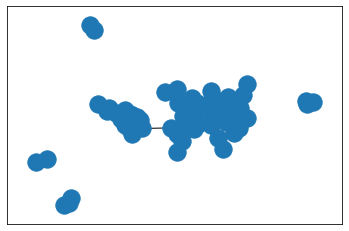

In [8]:
# ノードのラベルを非表示にしています
nx.draw_networkx(all_movie_graph, with_labels=False)

In [9]:
largest_component = max(
    nx.connected_components(all_movie_graph),
    key=len,
)
movie_graph = all_movie_graph.subgraph(largest_component)

In [10]:
from pyvis.network import Network

# 描画する際のサイズを指定できます
nt = Network(height="800px", width="800px", notebook=True, cdn_resources="in_line")
nt.from_nx(movie_graph)
nt.show("movie_graph.html")

movie_graph.html


In [11]:
titles["production_countries"].value_counts().head()

production_countries
['US']          43
['IN']          29
['EG', 'FR']     3
['GB']           3
['US', 'JP']     2
Name: count, dtype: int64

In [12]:
for node in movie_graph:
    # nodeはタイトルのIDになっているのでDataFrameの行を取得
    row = titles.loc[node]
    # ノードのtitle属性に、映画のタイトルと制作した国を追加
    movie_graph.nodes[node][
        "title"
    ] = f"{row['title']} {row['production_countries']}"
    # 文字列からeval関数でリストを生成
    countries = eval(row["production_countries"])
    # 国ごとに色分け
    if len(countries) == 1:
        if countries[0] == "US":
            movie_graph.nodes[node]["color"] = "#636EFA"  # 青
        if countries[0] == "IN":
            movie_graph.nodes[node]["color"] = "#EF553B"  # 赤
            # 以下のようにshape属性を指定できます。
            # movie_graph.nodes[node]["shape"] = "ellipse"
    else:
        movie_graph.nodes[node]["color"] = "#00CC96"  # 緑
        # movie_graph.nodes[node]["shape"] = "box"  # 青

In [13]:
nt = Network("800px", "800px", notebook=True, cdn_resources="in_line")
nt.from_nx(movie_graph)
nt.show("colored_movie_graph.html")

colored_movie_graph.html


### ノードの特徴を定量化する

In [14]:
# ノードのリストを作成
node_list = list(movie_graph.nodes())
# グラフに含まれるタイトルだけのDataFrame
titles_in_graph = titles.loc[node_list, :]
# 次数中心性の計算
deg_cent = nx.degree_centrality(movie_graph)
# degree centralityの列を追加
titles_in_graph["degree_centrality"] = [deg_cent[node] for node in node_list]

# 出力列を限定
cols = [
    "title",
    "production_countries",
    "degree_centrality",
]

# 次数中心性で降順にソート
titles_in_graph[cols].sort_values("degree_centrality", ascending=False)

,title,production_countries,degree_centrality
id,,,
tm67635,Kuch Kuch Hota Hai,['IN'],0.266667
tm58893,Duplicate,['IN'],0.253333
tm8859,Oh Darling! Yeh Hai India!,['IN'],0.240000
tm105716,Chaahat,['IN'],0.213333
tm118438,Anjaam,['IN'],0.200000
...,...,...,...
tm191431,Double Team,"['US', 'HK']",0.013333
tm12499,The Net,['US'],0.013333
tm54903,Wild Things,['US'],0.013333


In [15]:
# 媒介中心性を計算します。
bet_cent = nx.betweenness_centrality(movie_graph)

# 媒介中心性のデータを追加
titles_in_graph["betweenness_centrality"] = [bet_cent[node] for node in node_list]

# 出力列を限定
cols = [
    "title",
    "production_countries",
    "betweenness_centrality",
]

# 降順で並べ変えて表示
titles_in_graph[cols].sort_values(
    "betweenness_centrality",
    ascending=False,
)

,title,production_countries,betweenness_centrality
id,,,
tm191772,Seven Years in Tibet,['US'],0.493916
tm334788,Yodha,['IN'],0.481459
tm1822,3 Ninjas Kick Back,"['US', 'JP']",0.306412
tm191989,Donnie Brasco,['US'],0.287926
tm48430,Godzilla,['US'],0.218295
...,...,...,...
tm12499,The Net,['US'],0.000000
tm117488,The Next Karate Kid,['US'],0.000000
tm54903,Wild Things,['US'],0.000000
